# Introduction
This notebook shows the study of the [CWRU Bearing Dataset](https://csegroups.case.edu/bearingdatacenter/home), which contains data of normal and fault bearings. Artificial defects of different diameters (0.007 ~ 0.028 Inches) are manufactured at different locations of the bearings: inner raceway(IR), outer raceway(OR) and ball(B) defects. 

Experiments were conducted using a 2 hp Reliance Electri motor. Vibration data was recorded for motor loads of 0 to 3 hp (motor speed of 1797 to 1720 RPM) using accelerometers at the drive end (DE) and fan end (FE) and the data is stored as Matlab files. The sampling rate is 12 kHz and each Matlab file contains between ~120k to ~240k sample points. For more information please refer to the [website](https://csegroups.case.edu/bearingdatacenter/home).

This study focuses on the classification of the drive end bearing defects using only the signal data at **DE**. It is a **multiclass classification** problem. The input is the vibration signal data at DE and the output is the type of defects, i.e. **Normal, IR, OR, B**.


# Import and Define Helper Functions

In [1]:
# Data science libraries
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

# Others
from IPython.core.debugger import set_trace
from pathlib import Path

from helper import *
from train_helper import *
import nn_model
from one_cycle import OneCycle, update_lr, update_mom

In [2]:
working_dir = Path()
save_model_path = working_dir / 'Model'
normal_path = working_dir / 'Data' / 'Normal'
DE_path = working_dir / 'Data' / '12k_DE'

# Preprocess

In [3]:
df_Normal = matfile_to_df(normal_path)
df_DE = matfile_to_df(DE_path)

In [4]:
df_DE.sample(5)

,filename,DE_time,label
50,OR021@12_2.mat,"[[-0.004873053892215568], [0.14740988023952095...",OR
39,OR007@3_3.mat,"[[0.10436457085828342], [0.625375249500998], [...",OR
31,IR028_3.mat,"[[-0.9338355], [-0.5749497], [0.3812653], [1.1...",IR
35,OR007@12_3.mat,"[[0.16438435129740517], [0.2150641117764471], ...",OR
26,IR021_2.mat,"[[-0.40202694610778444], [0.5482185628742515],...",IR


In [ ]:
n_plots = 10
df_plot = df_DE.sample(n_plots)
plt.figure(figsize=(15, 3*n_plots))
for i in range(n_plots):
    plt.subplot(n_plots, 1, i+1)
    plt.plot(df_plot.iloc[i,1])
    plt.ylim(-10, 10)
    plt.title(df_plot.iloc[i,0])
plt.tight_layout()

# Train Test Split

In [3]:
df_all = get_df_all(normal_path, DE_path, segment_length=500, normalize=True)
features = df_all.columns[2:]
target = 'label'

In [4]:
subsample_size = len(df_all) // 5
subsample_idx = np.random.permutation(len(df_all))[:subsample_size]
df_all = df_all.iloc[subsample_idx]

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(df_all[features], 
                                                      df_all[target], 
                                                      test_size=0.20, random_state=42, shuffle=True
                                                     )

In [6]:
bs = 64

In [7]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
train_dl, valid_dl = get_dataloader(train_ds, valid_ds, bs)

# SGD

In [70]:
%%time
model = CNN_1D(len(features))
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
# opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)
model, train_loss, val_loss = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

EPOCH 	 Val Loss 	 Accuracy
0: 	 0.04723 	 0.58427
1: 	 0.02335 	 0.51404
2: 	 0.02451 	 0.44663
3: 	 0.02342 	 0.49438
4: 	 0.02089 	 0.65449
5: 	 0.05216 	 0.44101
6: 	 0.02240 	 0.56742
7: 	 0.02366 	 0.62640
8: 	 0.02041 	 0.69101
9: 	 0.02006 	 0.66573
Wall time: 10min 23s


In [73]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
# opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)
model, train_loss, val_loss = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

EPOCH 	 Val Loss 	 Accuracy
0: 	 0.01645 	 0.77809
1: 	 0.01668 	 0.76404
2: 	 0.01569 	 0.77528
3: 	 0.01492 	 0.80056
4: 	 0.01741 	 0.74157
5: 	 0.01569 	 0.77528
6: 	 0.01451 	 0.82865
7: 	 0.01626 	 0.78090
8: 	 0.01504 	 0.81461
9: 	 0.01341 	 0.88483


In [81]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
# opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)
model, train_loss, val_loss = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

EPOCH 	 Val Loss 	 Accuracy
0: 	 0.01198 	 0.87079
1: 	 0.01197 	 0.89045
2: 	 0.01199 	 0.89326
3: 	 0.01228 	 0.89045
4: 	 0.01135 	 0.88483
5: 	 0.01221 	 0.89326
6: 	 0.01214 	 0.89045
7: 	 0.01205 	 0.89326
8: 	 0.01189 	 0.89045
9: 	 0.01210 	 0.88764
10: 	 0.01203 	 0.89888
11: 	 0.01165 	 0.89326
12: 	 0.01145 	 0.88764
13: 	 0.01145 	 0.89326
14: 	 0.01182 	 0.89326
15: 	 0.01184 	 0.89888
16: 	 0.01192 	 0.89607
17: 	 0.01187 	 0.88483
18: 	 0.01205 	 0.89607
19: 	 0.01206 	 0.89607
20: 	 0.01119 	 0.89045
21: 	 0.01215 	 0.89888
22: 	 0.01261 	 0.89888
23: 	 0.01194 	 0.89326
24: 	 0.01171 	 0.89888
25: 	 0.01144 	 0.89326
26: 	 0.01167 	 0.89888
27: 	 0.01162 	 0.89326
28: 	 0.01158 	 0.89888
29: 	 0.01132 	 0.90169


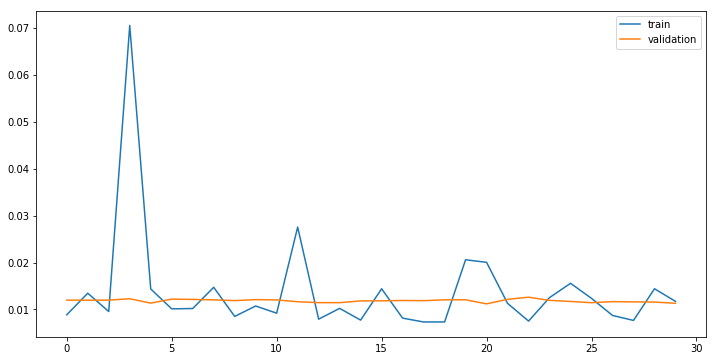

In [82]:
plt.figure(figsize=(12,6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='validation')
plt.legend()

In [ ]:
predictions = []
with torch.no_grad():
    model.eval()
    for xb, _ in valid_dl:
        pred = F.softmax(model(xb),dim=1)
        prob, pred = torch.max(pred,1)
#         print(pred.shape)
        predictions.append(pred)
        

In [ ]:
np.mean(y_valid.numpy() == torch.cat(predictions, dim=0).numpy())

In [ ]:
print(np.sum(y_valid.numpy() == torch.cat(predictions, dim=0).numpy()))
print(len(y_valid))

# Fit One Cycle

In [8]:
lr = 0.01
# bs = 64
wd = 1e-5
epochs = 3
loss_func = CrossEntropyLoss()
onecycle = OneCycle(int(len(X_train) * epochs / bs), lr, prcnt=10, div=25, momentum_vals=(0.95, 0.8))

In [9]:
%%time
model = nn_model.CNN_1D_2L(len(features))
# opt = optim.SGD(model.parameters(), lr=lr/10, momentum=0.95, weight_decay=wd)
opt = optim.Adam(model.parameters(), lr=lr/10, betas=(0.9, 0.999), weight_decay=wd)
model, metrics = fit(epochs, model, loss_func, opt, train_dl, valid_dl, one_cycle=onecycle, train_metric=True)

EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	
0 	 2.08909 	 2.25160 	 0.64338 	0.61667 	
1 	 0.26389 	 0.36656 	 0.89572 	0.86250 	
2 	 0.13145 	 0.21179 	 0.94508 	0.91111 	
Wall time: 53.9 s


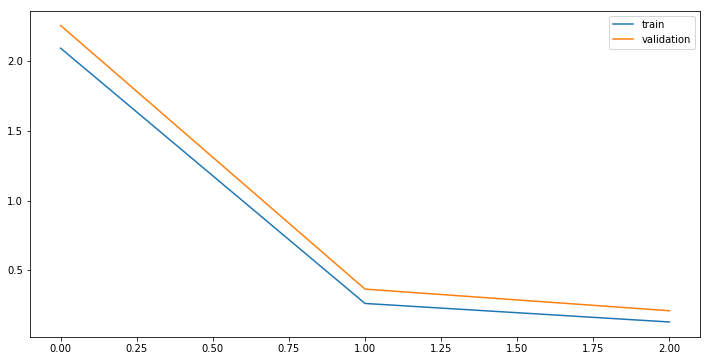

In [11]:
plt.figure(figsize=(12,6))
plt.plot(range(epochs), metrics["train_loss"], label='train')
plt.plot(range(epochs), metrics["val_loss"], label='validation')
plt.legend()

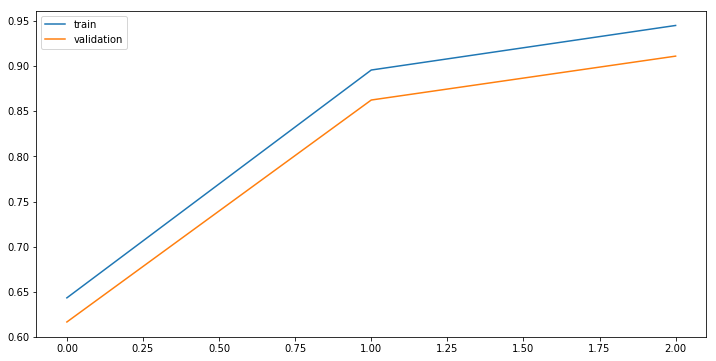

In [12]:
plt.figure(figsize=(12,6))
plt.plot(range(epochs), metrics["train_accuracy"], label='train')
plt.plot(range(epochs), metrics["val_accuracy"], label='validation')
plt.legend()

In [20]:
torch.save(model.state_dict(), save_model_path / 'model.pth')

In [36]:
model2 = CNN_1D_2L(len(features))

In [34]:
model2.load_state_dict(torch.load(save_model_path / 'model.pth'))
model2.eval()

CNN_1D(
  (layer1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (linear1): Linear(in_features=16384, out_features=4, bias=True)
)

In [17]:
%%time
print(validate(model, valid_dl, loss_func))

(0.21178718639744654, 0.9111111111111111)
Wall time: 810 ms
